# Lagrange Relaxation

Lagrange relaxation using annealing samplers {cite}`ohzeki2020`, called "Ohzeki method".

In [1]:
import dimod
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Original formulation:

$$
E(\mathbf{x}) = \mathbf{x}^{\mathrm{T}} Q \mathbf{x} + \frac{1}{2} \sum_{\mu=1}^M \lambda_{\mu} \left(\sum_{i=1}^{N} F_{\mu i} x_{\mu i} - C_{\mu}\right)^{2}
$$

Lagrange relaxation:

$$
E(\mathbf{x}, \mathbf{\nu}) = \mathbf{x}^{\mathrm{T}} Q \mathbf{x} - \sum_{\mu=1}^M \nu_{\mu} \left(\sum_{i=1}^{N} F_{\mu i} x_{\mu i} - C_{\mu}\right)
$$

Algorithm:

1. Sampling $\mathbf{x}$ (with $\mathbf{\nu}$ fixed)

$$
E(\mathbf{x}, \mathbf{\nu}) = \mathbf{x}^{\mathrm{T}} Q \mathbf{x} - \sum_{\mu=1}^M \nu_{\mu} \sum_{i=1}^{N} F_{\mu i} x_{\mu i}
$$

2. Update lagrange multipliers $\mathbf{\nu}$ (with $\mathbf{x}$ fixed)

$$
\nu_{k}^{t+1}=\nu_{k}^{t}+\eta\left(C_{\mu}-\left\langle \sum_{i=1}^N F_{\mu i} x_{\mu i} \right\rangle\right)
$$

3. Repeat steps 1 and 2

In [2]:
class LagrangeRelax:
    """
    Lagrange Relaxation using annealing samplers.

    Attributes
    ----------
    cost : numpy.ndarray
        Cost function (QUBO matrix).
    constraints: list
        Equality constraints.
    """

    def __init__(self, cost, constraints):
        """
        Parameters
        ----------
        cost : numpy.ndarray
            Cost function (QUBO matrix).
        constraints: list
            Equality constraints.
        """
        self.cost = cost
        self.constraints = constraints

    def _make_qubo_matrix(self, multipliers):
        qubo = self.cost.copy()
        for k, (Fk, Ck) in enumerate(self.constraints):
            for i, Fki in Fk.items():
                qubo[i, i] -= multipliers[k, i] * Fki
        return qubo

    def optimize(self, init_multipliers, eta, num_iters, sampler, **sample_params):
        """
        Parameters
        ----------
        init_multipliers : numpy.ndarray
            Initial multipliers, which shape is (# of vars, # of constraints).
        eta: float
            Step width of the gradient method.
        num_iters: int
            The number of iterations.
        sampler: dimod.Sampler
            Annealing sampler.
        **sample_params:
            Parameters of the above sampler.

        Returns
        -------
        list
            The history of multipliers updated in each iteration.
        list
            The history of sampleset attained by the sampler in each iteration.
        """
        multipliers = init_multipliers.copy()

        multipliers_hists = []
        sampleset_hists = []
        for _ in tqdm(np.arange(num_iters)):
            # Sampling
            qubo = self._make_qubo_matrix(multipliers)
            sampleset = sampler.sample_qubo(qubo, **sample_params)

            # Update multipliers
            sample_mean = np.mean(sampleset.record.sample, axis=0)
            for k, (Fk, Ck) in enumerate(self.constraints):
                Fk_mean = np.sum([Fki * sample_mean[i] for i, Fki in Fk.items()])
                multipliers[k] += eta * (Ck - Fk_mean)

            multipliers_hists.append(multipliers.copy())
            sampleset_hists.append(sampleset)

            # TODO: Convergence test

        return multipliers_hists, sampleset_hists

## Ex. K-hot constraint

Original formulation:

$$
E(\mathbf{x}) = \mathbf{x}^{\mathrm{T}} Q \mathbf{x} + \frac{\lambda}{2} \left(\sum_{i=1}^{N} x_{i} - K\right)^{2}
$$

Lagrange relaxation:

$$
E(\mathbf{x}, \mathbf{\nu}) = \mathbf{x}^{\mathrm{T}} Q \mathbf{x} - \nu \left(\sum_{i=1}^{N} x_{i} - K\right)
$$

In [3]:
# Cost function (to minimize)
N = 20  # The number of variables
R = 5  # Rank
A = np.random.normal(size=(R, N))
cost = np.dot(A.T, A) / len(A)  # QUBO matrix

In [4]:
# K-hot constraint
K = 3
constraints = [({i: 1 for i in range(N)}, K)]

In [5]:
# Using SA sampler
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()

# Using D-Wave quantum annealer
# from dwave.system import DWaveCliqueSampler
# sampler = DWaveCliqueSampler(solver='', token='')

In [27]:
init_multipliers = np.zeros((len(constraints), N))

lag_relax = LagrangeRelax(cost, constraints)
multipliers_hists, sampleset_hists = lag_relax.optimize(init_multipliers, eta=0.01, num_iters=20, sampler=sampler, num_reads=100)

100%|██████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.48it/s]


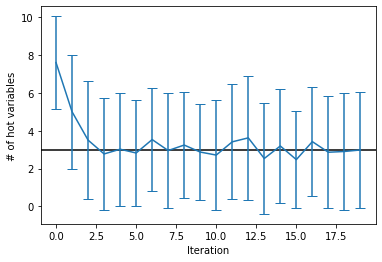

In [28]:
count_mean = [np.mean(np.sum(sampleset.record.sample, axis=1)) for sampleset in sampleset_hists]
count_std = [np.std(np.sum(sampleset.record.sample, axis=1)) for sampleset in sampleset_hists]

plt.axhline(K, c='k')
plt.errorbar(range(len(sampleset_hists)), count_mean, count_std, capsize=5)
plt.xlabel('Iteration')
plt.ylabel('# of hot variables')
plt.show()

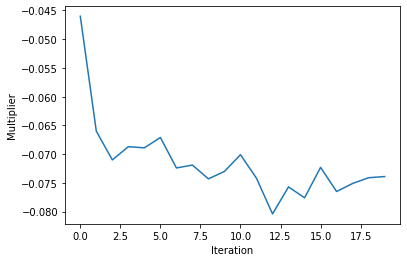

In [29]:
plt.plot(range(len(multipliers_hists)), [np.mean(mp[:, 0]) for mp in multipliers_hists])
plt.xlabel('Iteration')
plt.ylabel('Multiplier')
plt.show()

## References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```